## About
This notebook ...

This notebook again unavoidably make extenisve use of internal holehouse lab tools, to the extent that extracting out that code from this notebook is not trivial.

IF you are reading this and you want intermediate data that you can't access, please message Alex and he'll re-write this in a way that intermediate data is read in instead of being calculated. However, this would require a major re-restructuring of the code so I didn't want to spend the time doing this until someone needed it. Happy to do it though :).

In [19]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Set rcParams for tick marks
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks (in points)
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks (in points)
plt.rcParams['xtick.major.width'] = 0.5  # Width of major ticks (in points)
plt.rcParams['xtick.minor.width'] = 0.5  # Width of minor ticks (in points)

plt.rcParams['ytick.major.size'] = 2  # Length of major ticks (in points)
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks (in points)
plt.rcParams['ytick.major.width'] = 0.5  # Width of major ticks (in points)
plt.rcParams['ytick.minor.width'] = 0.5  # Width of minor ticks (in points)

plt.rcParams['xtick.labelsize'] = 5  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 5  # Font size for y-axis tick labels


# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)


In [20]:
import protfasta
from finches.data import fingerprints
from tqdm import tqdm
import pickle
from sparrow import Protein

from tqdm import tqdm
from finches import Mpipi_frontend
mf = Mpipi_frontend()

In [21]:
from housetools.sequence_tools.sequence_conservation import ConservationCalculator
import yeastevo

# activate and pre-load the conservation object
CC = ConservationCalculator()

In [22]:
# define metapredict version we're going to read in from
metapredict_version = 'v3'

# read in ysn2-idr-eps dictionary
# the resulting dictionation data has the following structure
# data[ysn][idr_name][i] 
# where i = index from 0 to 36 that corresponds to the 36 chemical fingerprints
# associated with Mpipi. The VALUE here then is the variance associated with the epsilon 
# calculation between the orthologous IDRs and the i-th chemical fingerprint; so a bigger value
# means less chemical conservation and a smaller number means more chemical conservation
with open(f'generated_data/ysn2idrvar_metapredict_{metapredict_version}_disorder_0.8_50.pkl', 'rb') as file:
    data = pickle.load(file)

data2cons = {}

# read in ysn2-idr-aligned-seqs dictionary
# the resulting dictionation data has the following structure
# data[ysn][idr_name][<YSN>_<SPECIES>_<species_protein_id>] 
#
# and then each value here is the aligned IDR

with open(f'generated_data/ysn2idrs_{metapredict_version}_{metapredict_version}_disorder_0.8_50.pkl', 'rb') as file:
    ysn2aligned_idrs = pickle.load(file)


# reads in a mapping that maps ysn to uniprot ID and protein name
with open(f'generated_data/ysn2uniprot.pkl', 'rb') as file:
    ysn2uniprot = pickle.load(file)

# defines the chemical fingerprints used for calculating per-IDR epsilon; sets
# number and order correctly
chemical_fingerprint_dipeptides = list(fingerprints.mpipi_fingerprints.keys())



## Define consistent order for YSN and IDR_IDs
In much of this code we do the following:
1. Iterate over all the YSN 
2. For each YSN ID, iterate over the IDR IDs associated with that YSN, if any

The code below establishes (1) the defined order of YSN IDs and then (2) The defined order of IDR IDs for each YSN ID. This means we don't need to think about how a dictionary or mapping was built as we will always return YSN and IDR IDs in the same order

In [23]:
ysn_list = []
for ysn in ysn2aligned_idrs:
    ysn_list.append(ysn)

# the following dictionary maps YSNs to their associated IDRs identifiers (e.g. IDRX_<START>_<END>)
ysn2idr_id = {}
for ysn in ysn_list:
    ysn2idr_id[ysn] = list(ysn2aligned_idrs[ysn].keys())

In [24]:
def return_cervisiae_info(ysn, idr_id=None):
    """
    Function that takes the YSN and returns EITHER:
    
    1. A list of 1 or more elements with [ysn, idr_identifier, 
       [ysn_species, unaligned cerevisiae sequence]] if no idr_id
        is provided.
       
    2. OR if an idr_id is provided, a list with 3 elements [ysn, 
       idr_identifier, [ysn_species, unaligned cerevisiae sequence]]
    

    Parameters
    --------------
    ysn : str
        YSN identifier

    idr_id : str 
        IDR identifier. Default = None means we return a list of 1 or more
        IDRs, as described below. If set to a value we return a single list 
        with 3 elements (IDR ID and sequence) [ysn, idr_id, [ysn_species, seq]]
        

    Returns
    --------------
    list
        Returns EITHER a 
        1. A list of lists, where each element in the lists consists of
           [ysn, idr_identifier, [ysn_species, unaligned cerevisiae sequence]]

        2. A list of lists, where the return list is a SINGLE result of 
           [ysn, idr_identifier, [ysn_species, unaligned cerevisiae sequence]]
        
    """

    # check the YSN can be found
    if ysn not in ysn2aligned_idrs:
        raise Exception(f'Invalid ysn {ysn}')
        
    final_returns = []

    # if no idr_id was passed, then we cycle over all idr_ids associated
    # with this YSN
    if idr_id is None:

        # for each idr_id associated with this ysn
        for idr_id in ysn2idr_id[ysn]:        
    
            return_tmp = []

            # x here is a string of format <ysn>_<species>_<species specific ID>
            for x in ysn2aligned_idrs[ysn][idr_id]:
                if x.find('Scerevisiae') >-1:

                    # adds a 2-position list of [0] - id and [1] sequence with no gaps
                    return_tmp.append([x, ysn2aligned_idrs[ysn][idr_id][x].replace('-','')])

            
            final_returns.append([ysn, idr_id, return_tmp[0]])      
    
    # if we passed a specific IDR ID...
    else:
        return_tmp = []

        # x here is a string of format <ysn>_<species>_<species specific ID>
        for x in ysn2aligned_idrs[ysn][idr_id]:

            
            if x.find('Scerevisiae') >-1:
                
                # adds a 2-position list of [0] - id and [1] sequence with no gaps
                return_tmp.append([x,ysn2aligned_idrs[ysn][idr_id][x].replace('-','')])

        # note in th
        final_returns = [ysn, idr_id, return_tmp[0]]
        
        
    return final_returns


## Build conservation scores
The code below cycles through each YSN and
1. Reads in the FASTA file with the aligned IDRs (note aligned IDRs here means we aligned ONLY on the IDRs having first extracted the IDRs from the orthologs. Note also the IDRs here are filtered in a pretty conservative way so they are all over 50 amino acids in S. cerevisiae and the S. cerevisiae IDR is at least 80% disordered in isolation

2. Calculate average per-residue conservation for the MSA associated with the aligned IDR (i.e. a single 'conservation' value for each IDR).

This cell creates the dictionary `data2cons` which has the structure


    data2cons[ysn][idr_name]

Where the value associated with each subdomain is the IDR-centric sequence conservation.

In [26]:
# build ysn-idr-conservation score
# This only takes ~20-30 seconds...
for ysn in tqdm(ysn_list):
    data2cons[ysn] = {}
    for d in data[ysn]:
        
        input_name = f'idr_msas/metapredict_{metapredict_version}/IDR_aligned/ALIGNED_{ysn}_{d}.fasta'        

        # read in aligned fasta
        aligned = protfasta.read_fasta(input_name,alignment=True)

        # calculate AVERAGE conservation for the IDR
        data2cons[ysn][d] = np.mean(CC.calculate_conservation(aligned,gap_cutoff=0.999).overall_conservation_scores)

100%|██████████| 5430/5430 [00:15<00:00, 343.64it/s]


## Calculate absolute lists
The cell below creates some simple lists that walk through all IDRs in the dataset in one single list in a defined order. The key lists generated here are


* cons_vals - per-IDR sequence conservation score
* sc_idr_length - per IDR sequence length
* all_yeasts_seqs - per IDR information (`[ysn, idr_identifier, [ysn_species, unaligned cerevisiae sequence]]`)

In [27]:
# initialize data structures to hold chemistry. Each value in the chem_vals dictionary will be
# a list that will hold a LOT of epsilon variance values. The idea here is that each value
# contains variances for all IDRs we're looking at here vs. one specific chemical fingerprint.
chem_vals = {}
for idx in range(36):
    chem_vals[idx] = []

# this list will hold IDR conservation values
cons_vals = []
sc_idr_length = []
all_yeasts_seqs = []

# for each YSN
for ysn in ysn_list:

    # for each IDR associated with that YSN
    for idr in ysn2idr_id[ysn]:

        # add (in order) the conservation value associated with that IDR
        cons_vals.append(data2cons[ysn][idr])

        # add (in order) info on that IDR; tmp here is a 3-element list
        # with [ysn, idr_id, [ysn_species, unaligned cerevisiae sequence]]
        tmp = return_cervisiae_info(ysn,idr_id=idr)
        all_yeasts_seqs.append(tmp)

        # get the IDR lengh out 
        sc_idr_length.append(len(tmp[2][1]))

        # for EACH fingerprint chemistry add (in order) the epsilon variance associated with
        # the orthologous IDRs and the idx-th chemistry, so chem_vals[idx] has 36 lists, each
        # of which len(chem_vals[0]) == len(cons_vals)
        for idx in range(len(chemical_fingerprint_dipeptides)):

            # recal "data" is the epsilon variance for the ysn/idr combo for all orthologs calculated
            # against the idx-th fingerprint sequence
            chem_vals[idx].append(data[ysn][idr][idx])

In [28]:
chem_vals_mean = []
chem_vals_std = []
for i in chem_vals:    
    chem_vals_mean.append(np.mean(chem_vals[i]))
    chem_vals_std.append(np.std(chem_vals[i]))

In [29]:
#all_yeasts_seqs.append(return_cervisiae_info(ysn))

In [ ]:
def calculate_conserved_idrs(cons_vals, 
                             chem_vals, 
                             all_yeasts_seqs, 
                             seq_cons_threshold = 0.35, 
                             chemical_percentile = 10):

    """
    Function that calculates which IDRs are conserved both
    in sequence and chemical properties.

    This function takes in conservation values, chemical variance values, and
    aligned sequences for each IDR, and identifies which IDRs are conserved
    based on specified thresholds for both sequence and chemical properties.

    Parameters
    -----------------------
    cons_vals : list
        List where each value is the conservation score of the IDR in the order
        defined in the notebook.

    chem_vals : dict
        Dictionary where each key is an integer index corresponding to a
        specific chemical fingerprint, and each value is a list of epsilon
        variance values for all IDRs in the same order as cons_vals.

    all_yeasts_seqs : list
        List where each value is a list of the form [ysn, idr_id, [ysn_species, 
        unaligned cerevisiae sequence]] 

    seq_cons_threshold : float
        Sequence conservation threshold below which an IDR is considered
        conserved. Default is 0.35.
    
    chemical_percentile : float
        Chemical percentile threshold below which an IDR is considered
        conserved in terms of its chemical properties. Default is 10.

    Returns 
    -----------------------
    all_conserved : dict
        Dictionary where each key is a unique IDR identifier (formatted as
        "ysn_idr_id") and each value is the corresponding entry from
        all_yeasts_seqs for IDRs that are conserved in both sequence and
        chemical properties.    

    """

    all_conserved = {}
    tracker = {}
    conserved_by_chemistry = {}    
    
    # select a chemistry index to focus on (i.e. this chem_idx will be and
    # integer from 0 to 35 corresponding to the 36 chemical fingerprints)
    for chem_idx in chem_vals:


        # define a threshold score that reflects the bottom $chemical_percentile
        # variance of the chemical interaction data - i.e. IDRs where epislon
        # variance is smol.
        chem_thresh = np.percentile(chem_vals[chem_idx], chemical_percentile)

        # get the dipeptide name (chemical_fingerprint_dipeptides is a global)
        chem_dipeptide = chemical_fingerprint_dipeptides[chem_idx]

        # initialize the conserved by chemistry dictionary 
        conserved_by_chemistry[chem_dipeptide] = []
    
        # for each index that will index into:
        #
        #    chem_vals[chem_idx][i]
        #    all_yeasts_seqs[i]
        #    cons_vals[i]
        #
        # where in all three cases we're referring to the same IDR        
        for i in range(len(cons_vals)):
            
            # if the sequence is conserved below the threshold
            if cons_vals[i] < seq_cons_threshold:

                # if the chemical variance for this IDR is below the emprical
                # percentiled threshold
                if chem_vals[chem_idx][i] < chem_thresh:

                    # define the unique ID for this IDR
                    unique_id = all_yeasts_seqs[i][0]+"_"+all_yeasts_seqs[i][1]

                    # update the chemical_percentile dictionary appropriately
                    conserved_by_chemistry[chem_dipeptide].append(all_yeasts_seqs[i])

                    # if we've seen this IDR before...
                    if unique_id in tracker:
                        tracker[unique_id].append(chem_dipeptide)

                    # else first time addition
                    else:                        
                        all_conserved[unique_id] = all_yeasts_seqs[i]
                        tracker[unique_id] = []
                        tracker[unique_id].append(chem_dipeptide)

    return [all_conserved, conserved_by_chemistry, tracker]
                        
X = calculate_conserved_idrs(cons_vals, chem_vals, all_yeasts_seqs, )





# Show how fraction of IDRs relates to thresholds
Illustrate how 

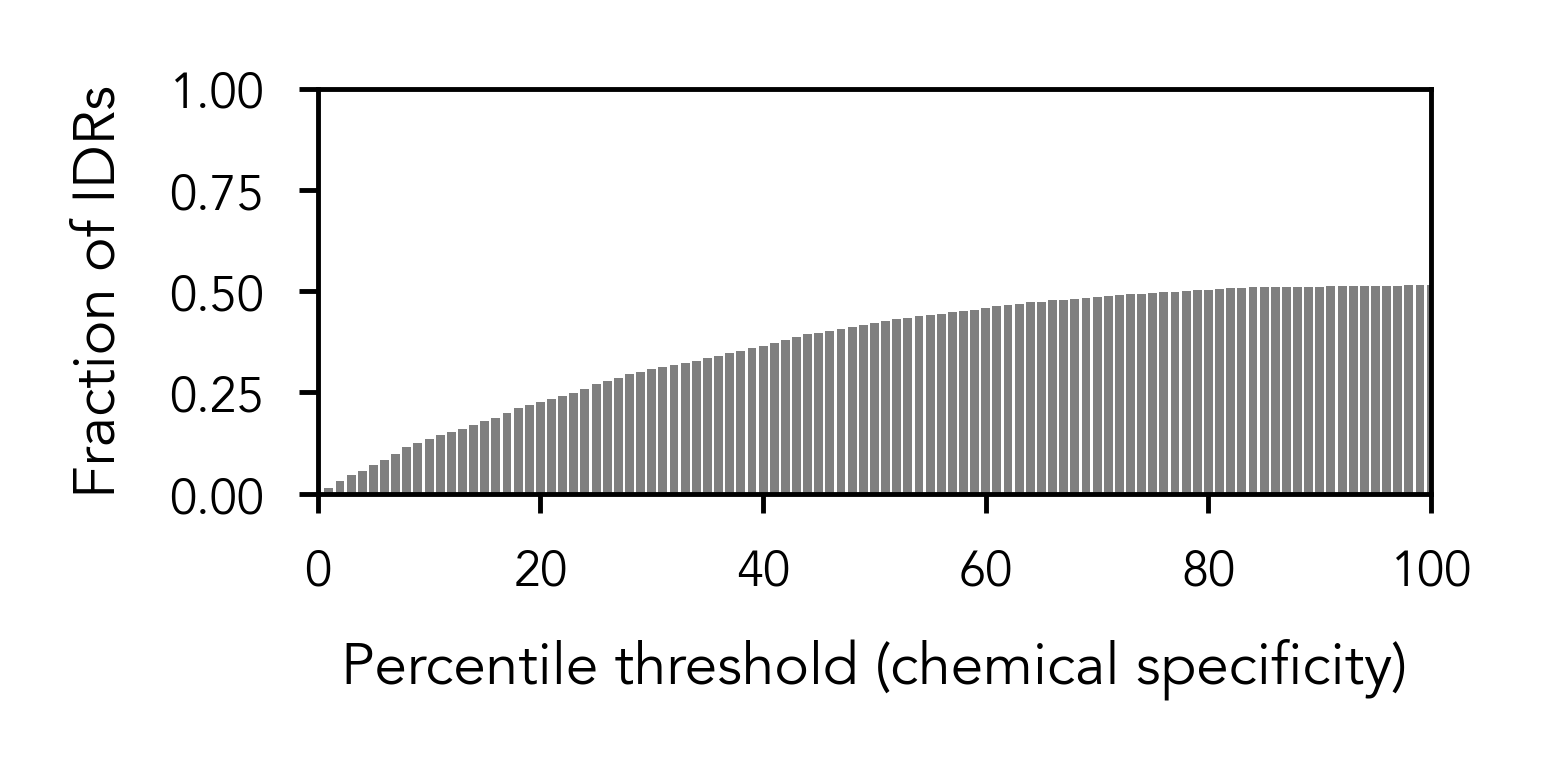

In [31]:
counts = []
end_pcntile=100
seq_cons_threshold=0.35
percentile_vals = np.arange(1,end_pcntile+1)
for i in percentile_vals:
    X = calculate_conserved_idrs(cons_vals, chem_vals, all_yeasts_seqs, chemical_percentile=i, seq_cons_threshold=seq_cons_threshold)
    
    counts.append(len(X[0]))

figure(None, (2.3,1.2), dpi=350)
ax = plt.gca()

plt.bar(percentile_vals, np.array(counts)/len(cons_vals),color='k', alpha=0.5)
plt.ylim([0,1])
plt.yticks([0,0.25,0.5,0.75,1.0])
plt.xlim([0,end_pcntile])
plt.xlabel('Percentile threshold (chemical specificity)',fontsize=6)
plt.ylabel('Fraction of IDRs',fontsize=6)
plt.tight_layout()
plt.savefig(f'figures/yeast_idrs_metapredict_{metapredict_version}_seq_cons_{seq_cons_threshold}.pdf')

In [35]:
# find conserved IDRs with the thresholds we settle on
seq_cons_threshold=0.35
chemical_percentile=15


all_conserved_idrs = calculate_conserved_idrs(cons_vals, 
                                              chem_vals, 
                                              all_yeasts_seqs, 
                                              seq_cons_threshold=seq_cons_threshold, 
                                              chemical_percentile=chemical_percentile)


The resulting all_conserved_idrs is a list with a bunch of info...

#### Element 0 i s a dictionary 
This dictionary reports on all the IDRs that have low sequence conservation and high chemical interaction conservation, where low sequence conservation means a sequence conservation score of < `seq_cons_threshold` and high chemical interaction conservation 

* key - `<YSN>_<IDR_ID>`
* value - `[YSN, IDR, [<YSN>_<species>_<species_ID>, unaligned sequence]]`

#### Element 1 is a dictionary
This dictionary lets you map a specific type of chemistry from the fingerprint peptides to a list of IDRs conserved with respect to interact with that chemistry

* key - each of the 36 chemical dipeptides
* value - a list of all the IDRs conserved wrt that chemical interaction, where each IDR is represented as `[YSN, IDR_ID, [<YSN>_<species>_<species_ID>, unaligned sequence]]`


#### Element 2 is a dictionary
This dictionary maps each unique ID for an IDR (`<YSN>_<IDR_ID>`) to the list of one or more fingerprints which it was respected for

* key - each of the 36 chemical dipeptides
* value - a list of all the IDRs conserved wrt that chemical interaction, where each IDR is represented as `[YSN, IDR_ID, [<YSN>_<species>_<species_ID>, unaligned sequence]]`


In [40]:
# buld data for length correlation
different_fingerprint_counts = []
idr_lengths = []
unique_idr_to_counts = {}

for k in all_conserved_idrs[2]:
    different_fingerprint_counts.append(len(all_conserved_idrs[2][k]))
    idr_lengths.append(len(all_conserved_idrs[0][k][2][1]))
    unique_idr_to_counts[k] = len(all_conserved_idrs[2][k])

## Plot `chem_conservation_vs_length.pdf`
This figure says, for each IDR that's poorly conserved in terms of sequence but chemically conserved, how many different dipeptide fingerprints is the IDR conserved with respect to, for a min of 1 and a max of 36.

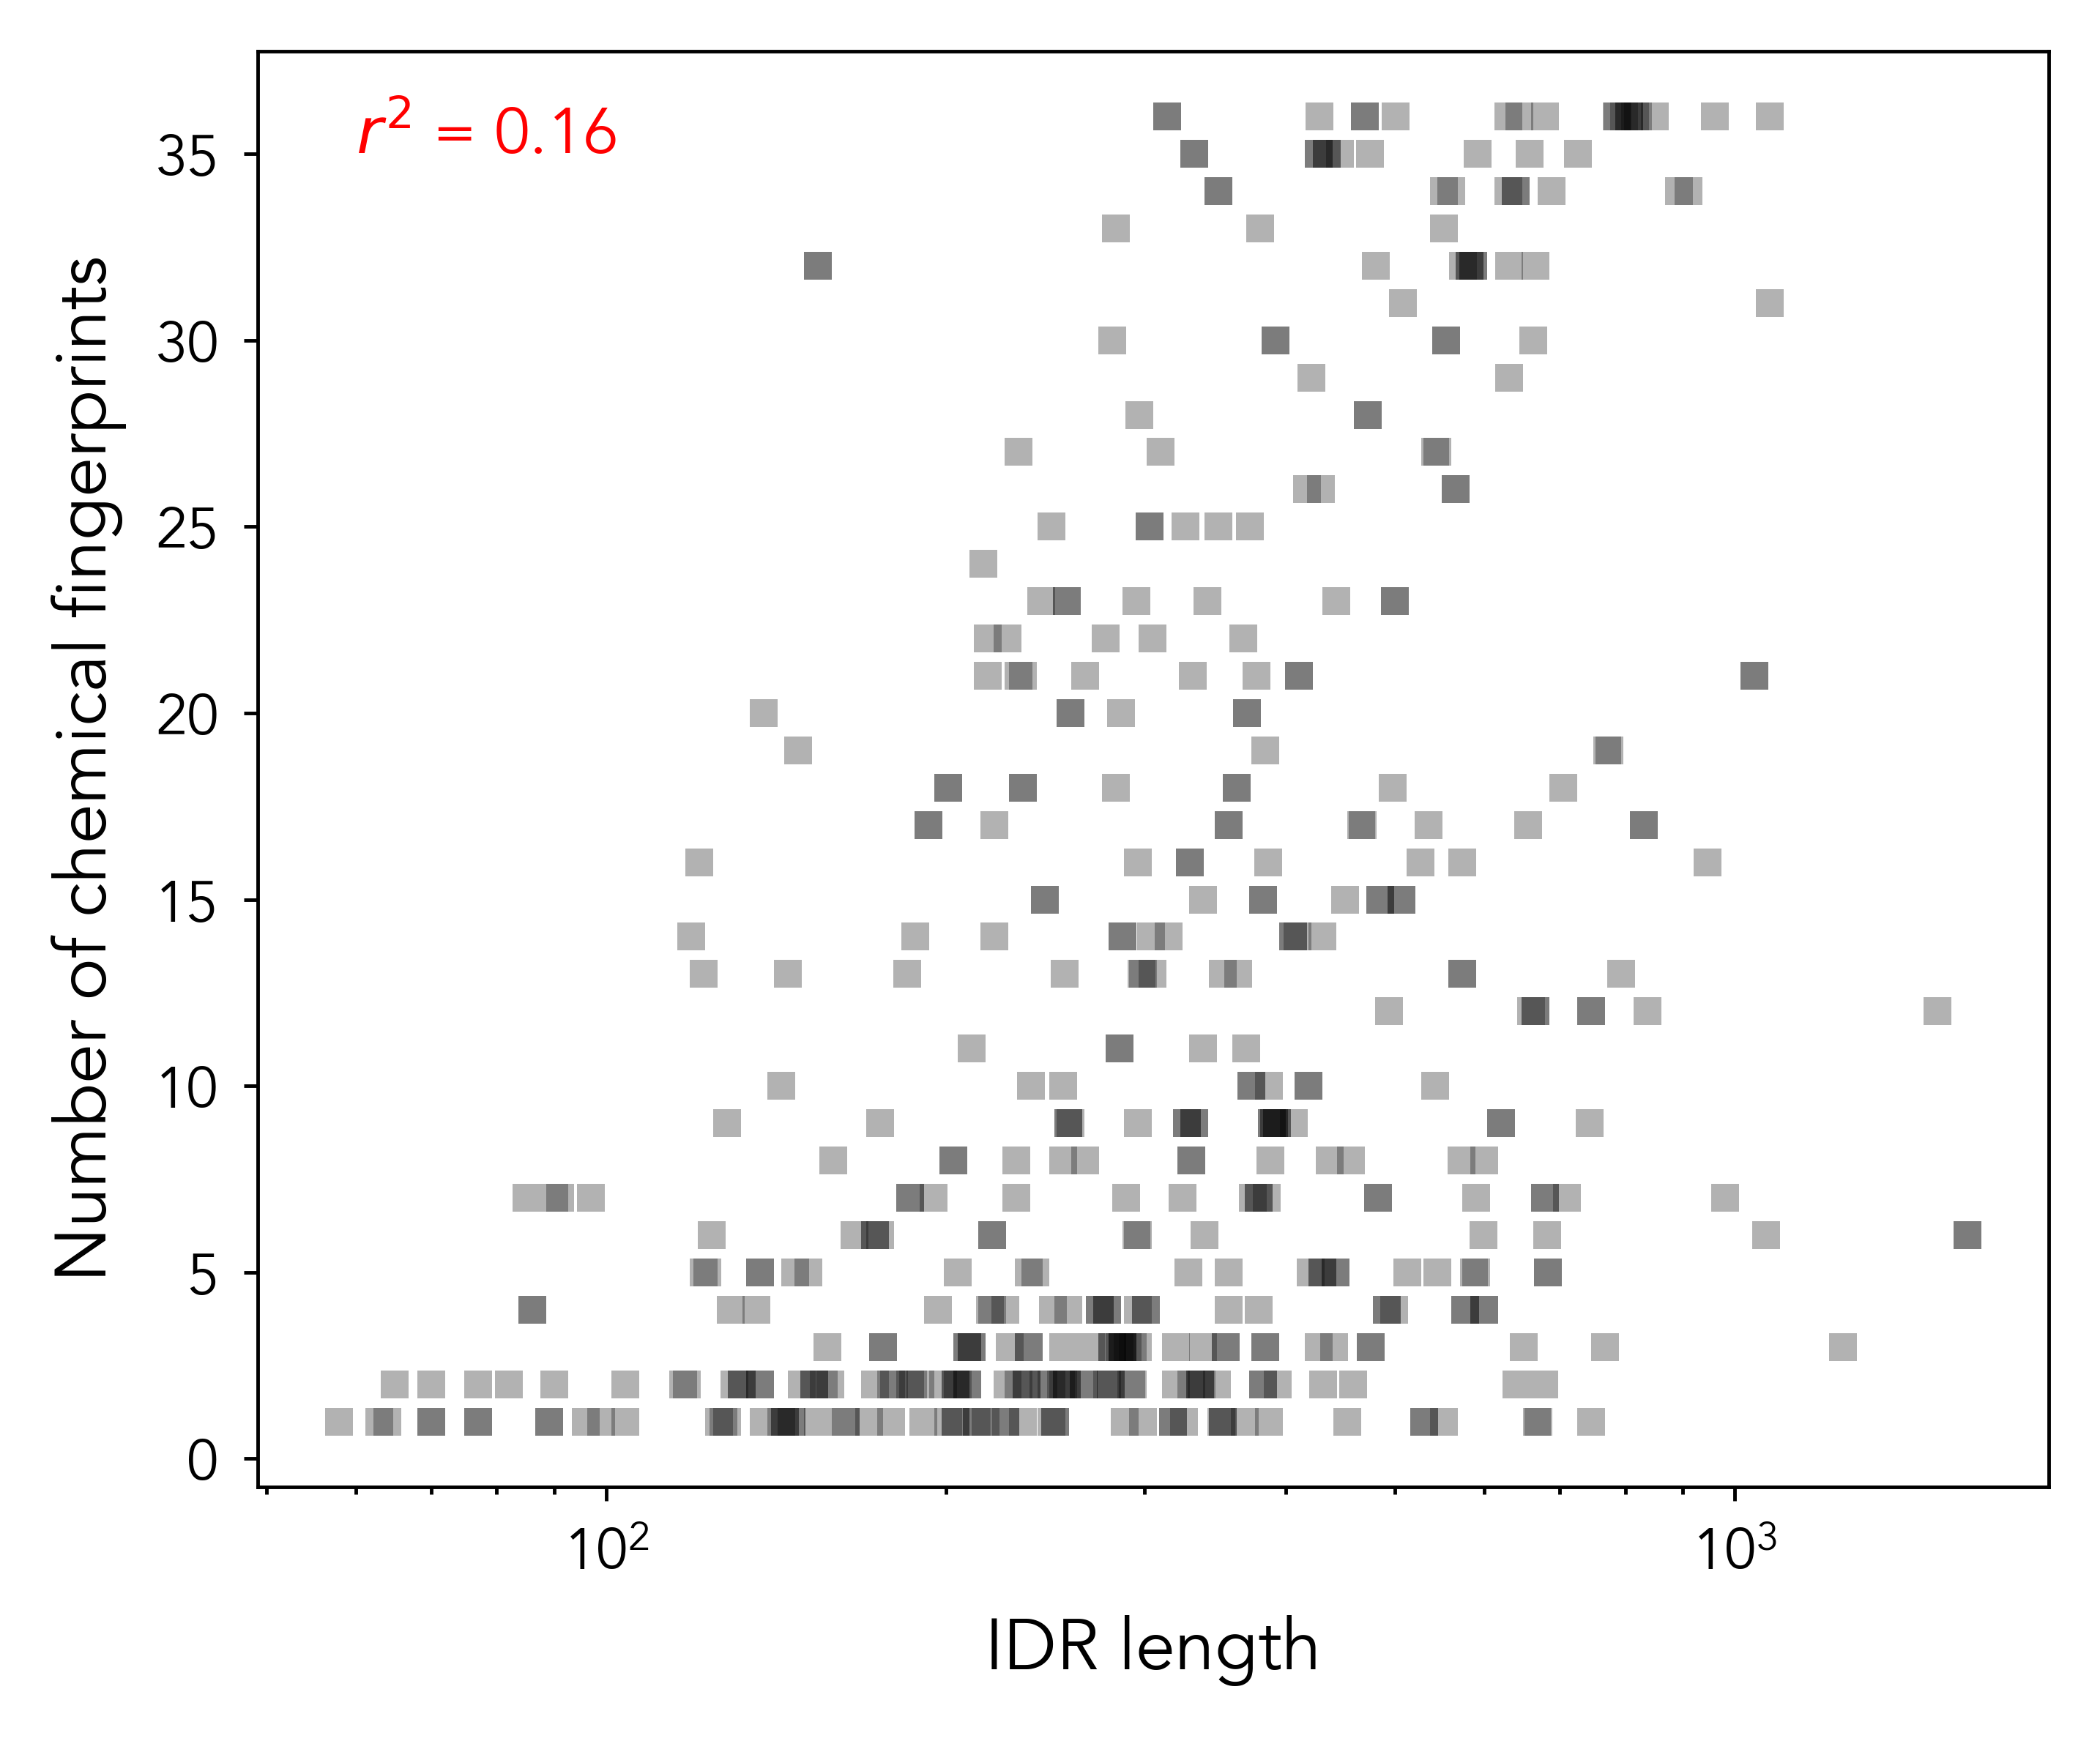

In [67]:
figure(None, (4.2, 3.5), dpi=350)
ax = plt.gca()

plt.plot(idr_lengths, different_fingerprint_counts,'s', ms=4, color='k', alpha=0.3, mew=0)
r2 = np.corrcoef(idr_lengths, different_fingerprint_counts)[0][1]**2

plt.xscale('log')

plt.xlabel('IDR length',fontsize=10)
plt.ylabel('Number of chemical fingerprints',fontsize=10)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.text(60, 35, r'${r^2}$' + f" = {round(r2,2)}", fontsize=9, color='r')
plt.tight_layout()
plt.savefig('figures/chem_conservation_vs_length.pdf')


## Plot `chem_conservation_histogram.pdf`
This figure says, histograms how many fingerprints each IDR is conserved with respect to.

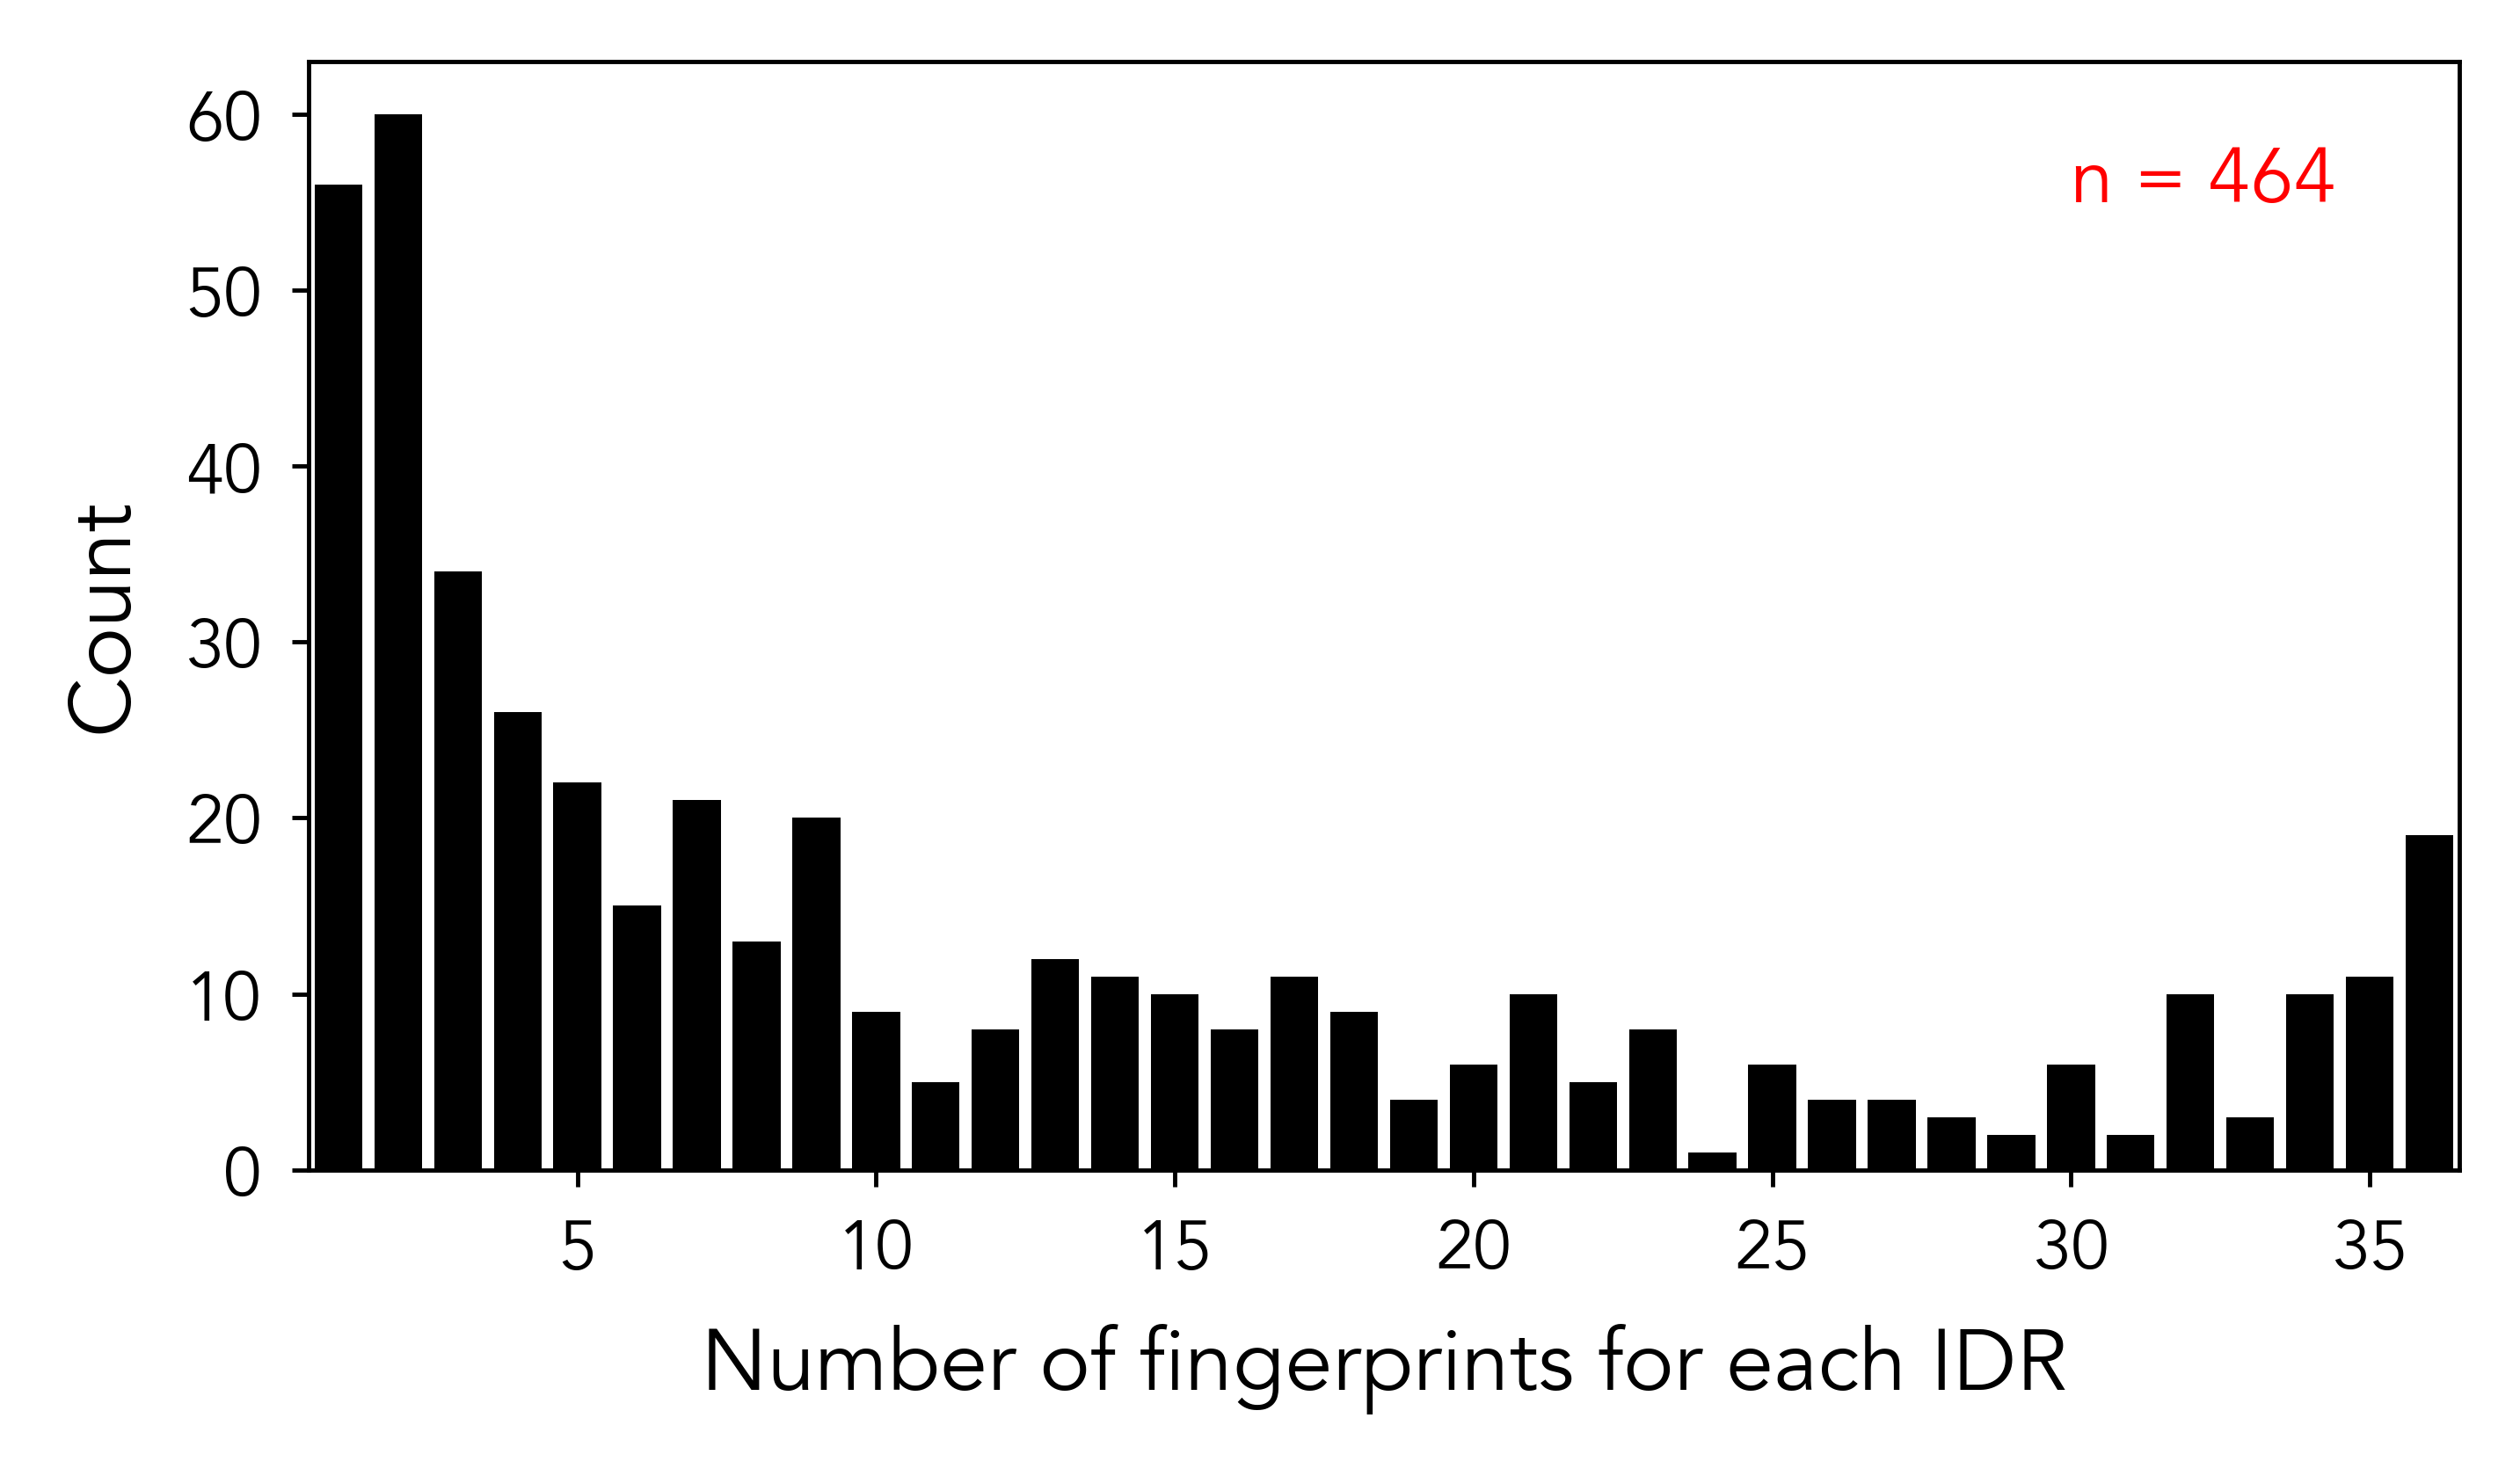

In [68]:
bins = np.arange(1,len(chemical_fingerprint_dipeptides)+2)
real_bins = np.arange(1,len(chemical_fingerprint_dipeptides)+1)
[a,b] = np.histogram(different_fingerprint_counts, bins=bins)

figure(None, (4.2, 2.5), dpi=350)
ax = plt.gca()
plt.bar(real_bins, a, color='k')
plt.xlim([0.5,36.5])

plt.xlabel('Number of fingerprints for each IDR',fontsize=10)
plt.ylabel('Count',fontsize=10)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.text(30, 55, f"n = {len(different_fingerprint_counts)}", fontsize=9, color='r')
plt.tight_layout()
plt.savefig('figures/chem_conservation_histogram.pdf')


In [46]:
# find those IDRs which are conserved with respect to 10 or more chemical fingerprints. We call these
# superconservers...
superconservers = []

number_conserved_fingerprints = 10
for fp in chemical_fingerprint_dipeptides:

    # d here is an element that is [ysn, idr, [<ysn>_<spec>_<spec id>, seq]]
    for d in all_conserved_idrs[1][fp]:
        ysn_idrid = d[0]+"_"+d[1]
        if unique_idr_to_counts[ysn_idrid] > number_conserved_fingerprints:
            superconservers.append(ysn_idrid)

superconservers = list(set(superconservers))
print(f"Found {len(superconservers)} superconservers!")


Found 188 superconservers!


In [ ]:
conserved_uid = []
for d in all_conserved_idrs[0]:
    ysn = d.split('_')[0]
    uid_info = ysn2uniprot[ysn]
    conserved_uid.append(uid_info[0])

conserved_uid = list(set(conserved_uid))
print(f"Found {len(conserved_uid)} proteins with IDRs!")


Found 441 conserved unique IDs!


In [48]:
superconservers_uid = []
for d in superconservers:
    ysn = d.split('_')[0]
    uid_info = ysn2uniprot[ysn]
    superconservers_uid.append(uid_info[0])
    
superconservers_uid = list(set(superconservers_uid))
print(f"Found {len(superconservers_uid)} proteins with superconserved IDRs!")


Found 183 proteins with superconserved IDRs!


In [64]:
all_chemically_conserved_idrs_aligned = {}
for ysn_idr in all_conserved_idrs[0]:    
    ysn    = ysn_idr.split('_')[0]
    idr_id = "_".join(ysn_idr.split('_')[1:])
    uid_info = ysn2uniprot[ysn]
    all_chemically_conserved_idrs_aligned[ysn_idr] = ysn2aligned_idrs[ysn][idr_id]
    if uid_info[0] in superconservers_uid:
        protfasta.write_fasta(all_chemically_conserved_idrs_aligned[ysn_idr],f'generated_data/aligned_chemically_conserved_hits/{uid_info[0]}_{ysn_idr}_superconserved.fasta')
    else:
        protfasta.write_fasta(all_chemically_conserved_idrs_aligned[ysn_idr],f'generated_data/aligned_chemically_conserved_hits/{uid_info[0]}_{ysn_idr}.fasta')


In [ ]:
with open('generated_data/conserved_idrs.tsv','w') as fh:
    for fp in all_conserved_idrs[0]:
        x = all_conserved_idrs[0][fp]
        ysn = x[0]
        idr_start = int(x[1].split('_')[1])+1
        idr_end   = int(x[1].split('_')[2])
        uid = ysn2uniprot[ysn][0]
        pname = ysn2uniprot[ysn][1]
        seq = x[2][1]
        outchem = all_conserved_idrs[2][fp]
        #print(outchem)
        chemistries = "; ".join(outchem)
        fh.write(f'{uid}\t{ysn}\t{pname}\t{idr_start}\t{idr_end}\t{chemistries}\t{seq}\n')
        